# Ассоциация пользователей Apriori

# Правила для сегментов заказов

In [1]:
# %% -------------------- 0. Импорт и настройки --------------------
import os, gc, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates
from scipy.stats import chi2_contingency
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
plt.style.use("default")

DATA_DIR = r"D:\instacart\archive"

In [2]:
# %% -------------------- 1. Загрузка данных --------------------
user_cluster   = pd.read_csv(os.path.join(DATA_DIR, "user_segments.csv"))

# NEW: сегменты заказов ────────────────
order_cluster  = pd.read_csv(os.path.join(DATA_DIR, "order_segments.csv"))
order_cluster.rename(columns={"order_id": "order"}, inplace=True)

df_tr   = pd.read_csv(os.path.join(DATA_DIR, "order_products__prior.csv"))
df_pr   = pd.read_csv(os.path.join(DATA_DIR, "products.csv"))
orders  = pd.read_csv(os.path.join(DATA_DIR, "orders.csv"), usecols=['order_id', 'user_id'])
df_aisl = pd.read_csv(os.path.join(DATA_DIR, "aisles.csv"), usecols=["aisle_id", "aisle"])

In [3]:
order_cluster.head()

,order,order_segment
0,1,3
1,2,0
2,3,0
3,4,0
4,5,0


In [4]:
orders.head()

,order_id,user_id
0,2539329,1
1,2398795,1
2,473747,1
3,2254736,1
4,431534,1


In [5]:
# %% -------------------- 2. Объединяем данные --------------------
df = (
    df_tr[df_tr["reordered"] == 1]
      .merge(df_pr,    on="product_id", how="left")
      .merge(df_aisl,  on="aisle_id",   how="left")
      .merge(orders.rename(columns={"order_id": "order_id"}), on="order_id", how="left")
      .loc[:, ["order_id", "user_id", "aisle"]]               # столбцы как раньше
)
print(f"Транзакций: {len(df):,}")

del df_tr, df_pr; gc.collect()

Транзакций: 19,126,536


0

In [6]:
df.rename(columns={"order_id": "order"}, inplace=True)
df.head()

,order,user_id,aisle
0,2,202279,eggs
1,2,202279,fresh vegetables
2,2,202279,oils vinegars
3,2,202279,fresh vegetables
4,2,202279,doughs gelatins bake mixes


In [7]:
# # Топ-5 популярных
# top_aisles_ids = aisle_counts.head(5)['aisle_id'].tolist()

# # Категории менее 10,000 заказов
# rare_aisles_ids = aisle_counts[aisle_counts['num_orders'] < 10000]['aisle_id'].tolist()

# # Все категории, которые не должны попасть в матрицу
exclude_aisles = {'fresh fruits', 'fresh vegetables', 'packaged vegetables fruits', 'yogurt', 'packaged cheese', 'eye ear care', 'baby bath body care', 'baby accessories', 'beauty', 'frozen juice'}
print("Исключаемые категории:", exclude_aisles)

Исключаемые категории: {'eye ear care', 'baby accessories', 'beauty', 'frozen juice', 'packaged cheese', 'baby bath body care', 'yogurt', 'packaged vegetables fruits', 'fresh vegetables', 'fresh fruits'}


Сегмент заказов 0
Частых aisle (≥1 % и прошли фильтрацию): 70
basket: (2152985, 70)
  → сильных правил: 44



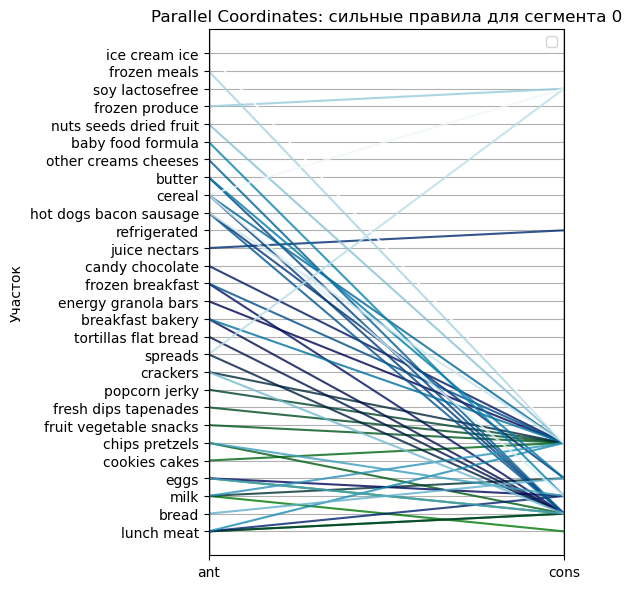

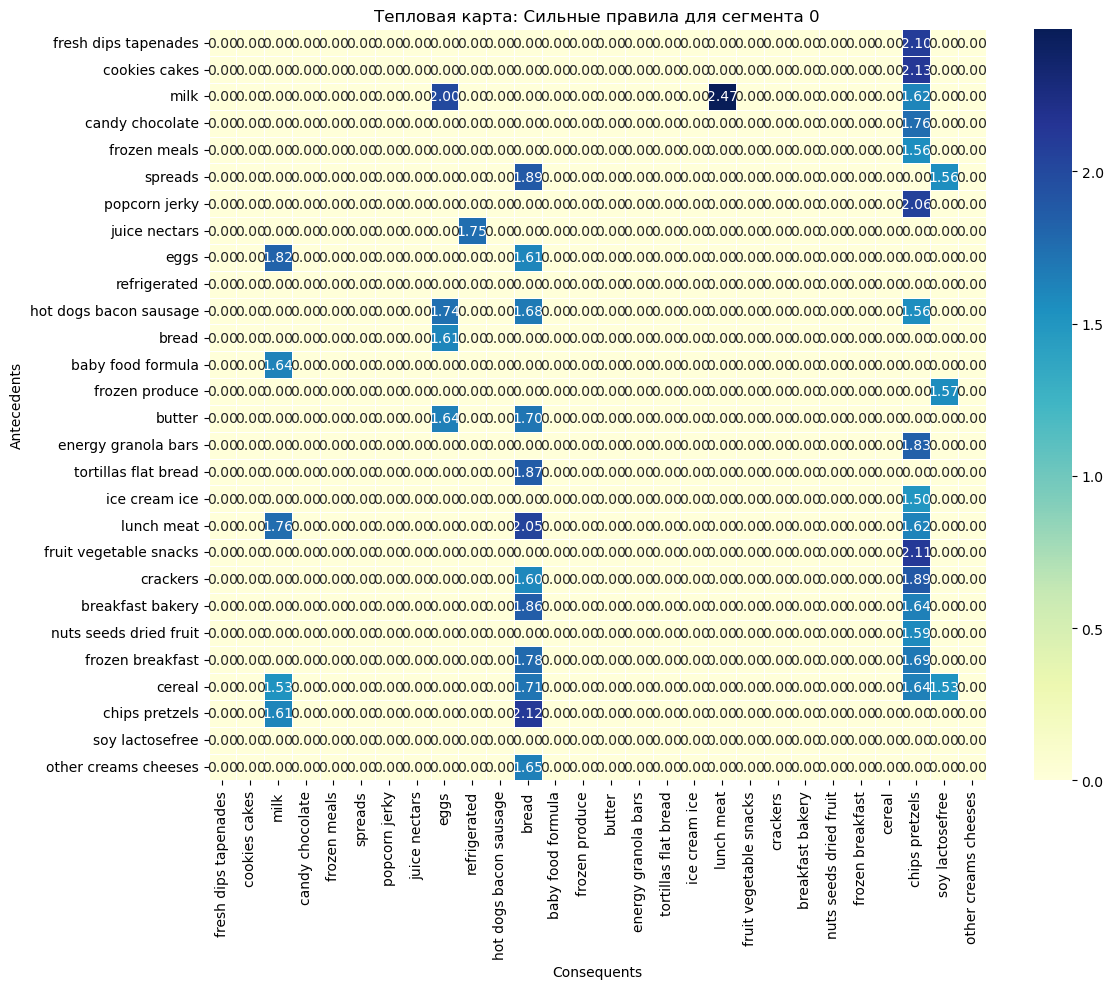

Сегмент заказов 1
Частых aisle (≥1 % и прошли фильтрацию): 71
basket: (41000, 71)
  → сильных правил: 33



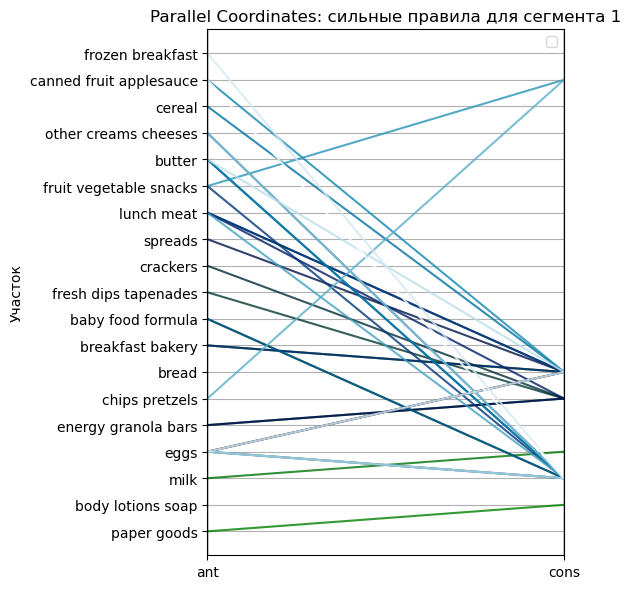

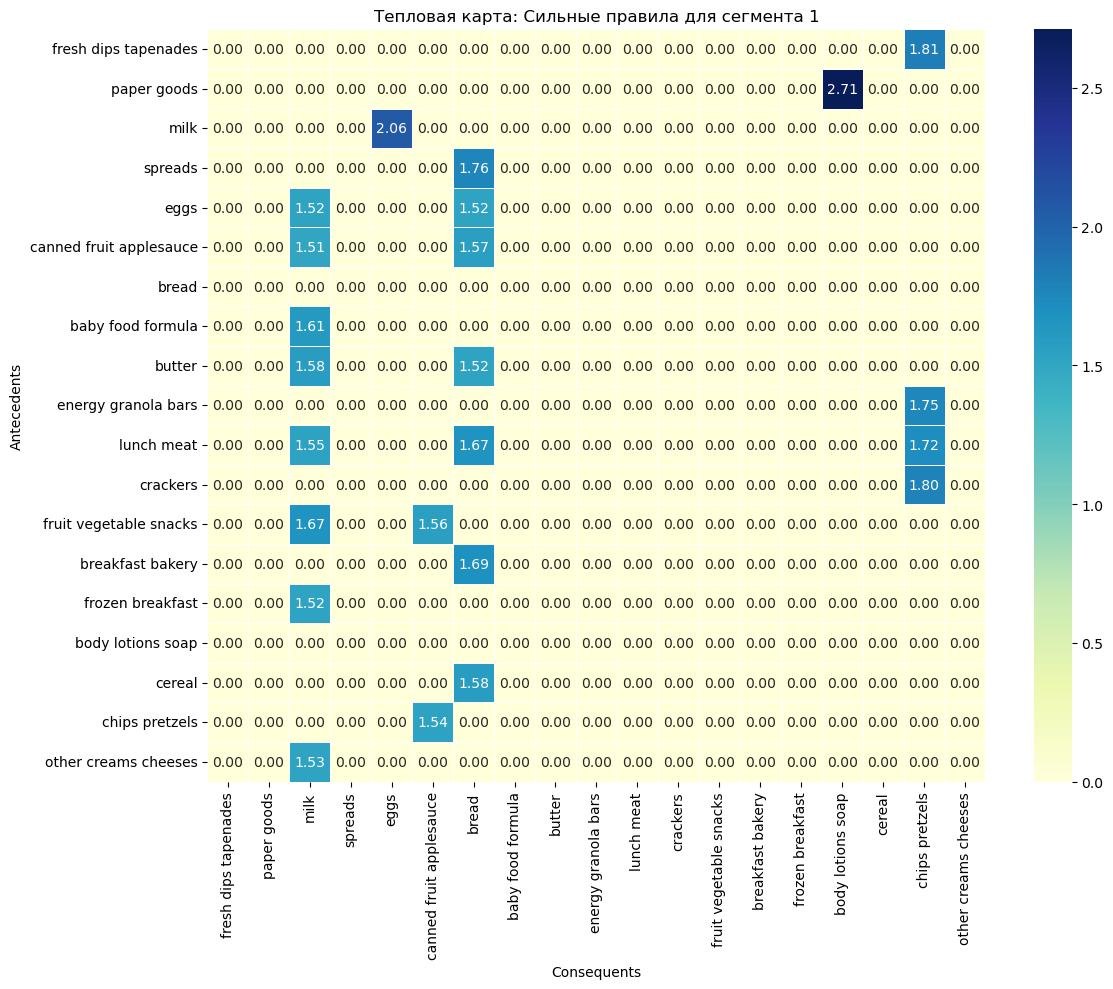

Сегмент заказов 2
Частых aisle (≥1 % и прошли фильтрацию): 52
basket: (9253, 52)
  → сильных правил: 1



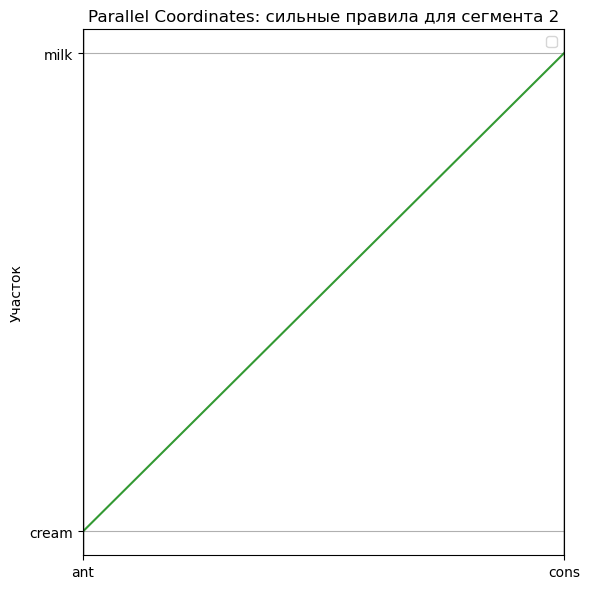

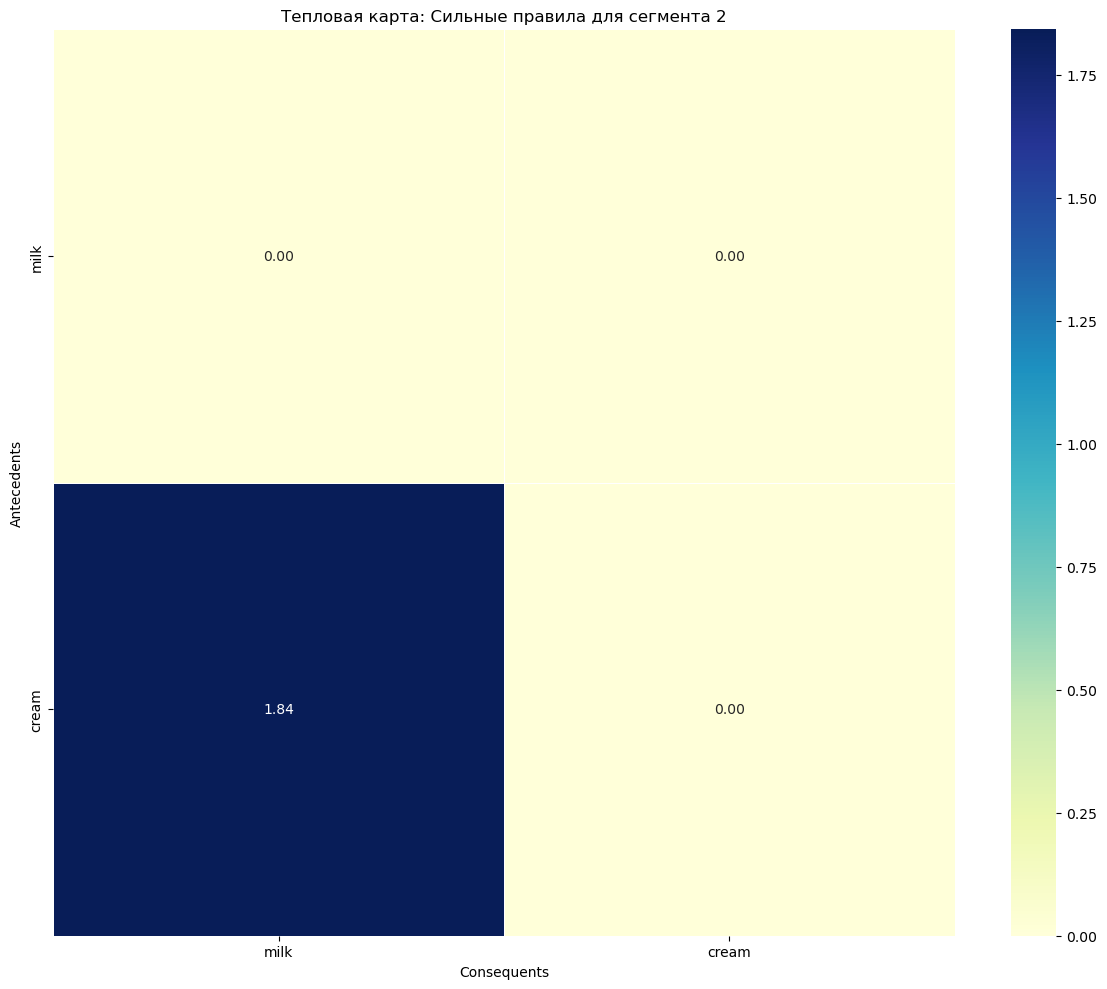

Сегмент заказов 3
Частых aisle (≥1 % и прошли фильтрацию): 62
basket: (11776, 62)
  → сильных правил: 41



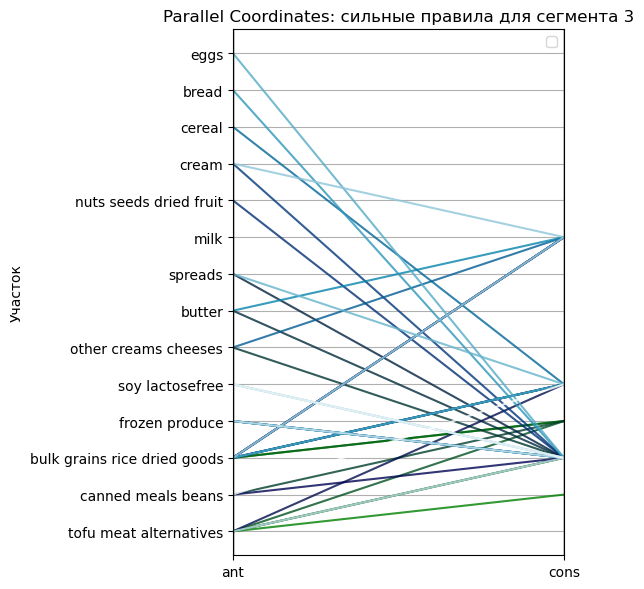

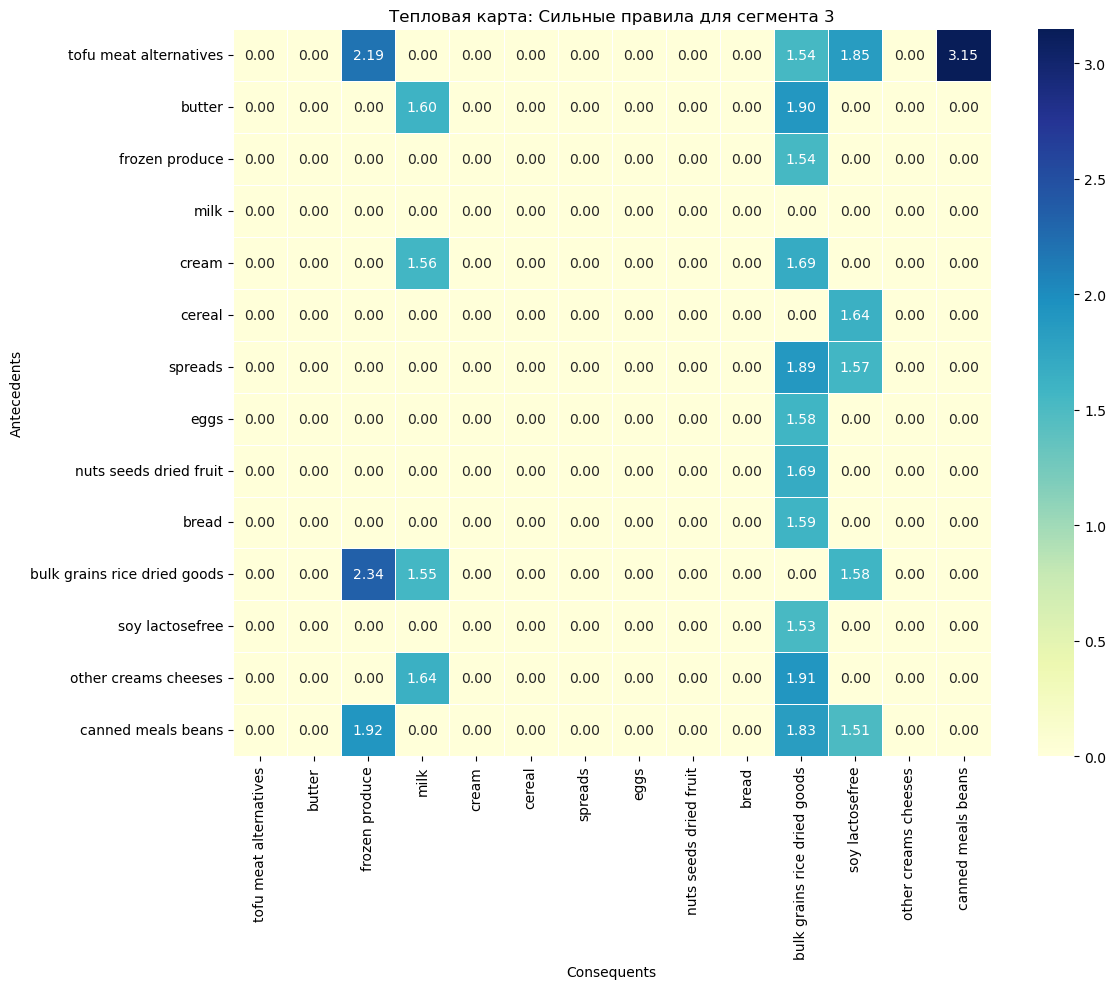

Сегмент заказов 4
Частых aisle (≥1 % и прошли фильтрацию): 71
basket: (242748, 71)
  → сильных правил: 54



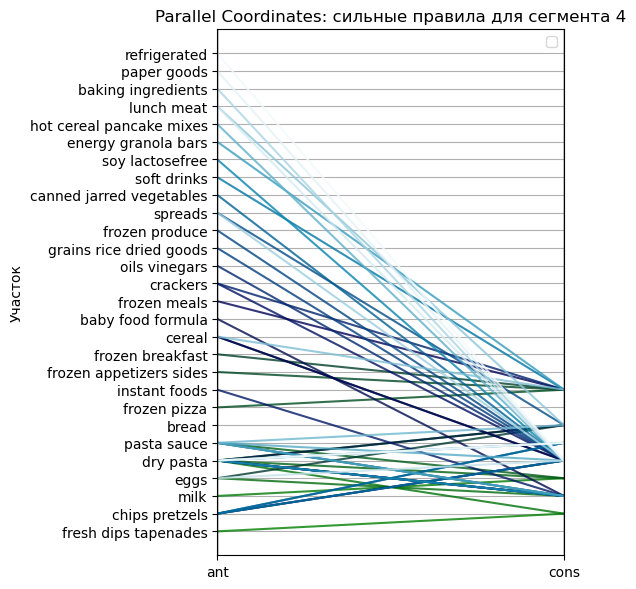

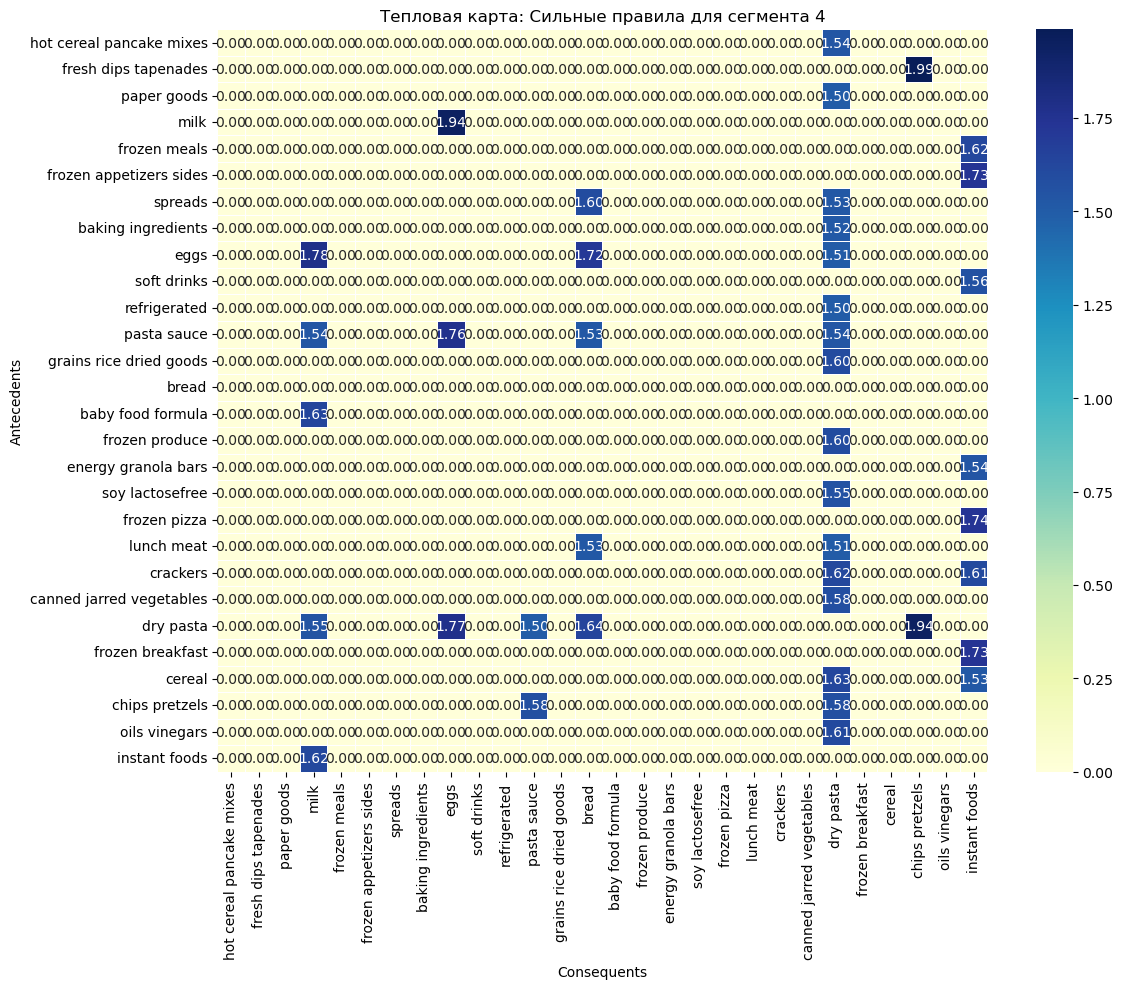

Сегмент заказов 5
Частых aisle (≥1 % и прошли фильтрацию): 31
basket: (12633, 31)
  → сильных правил: 2



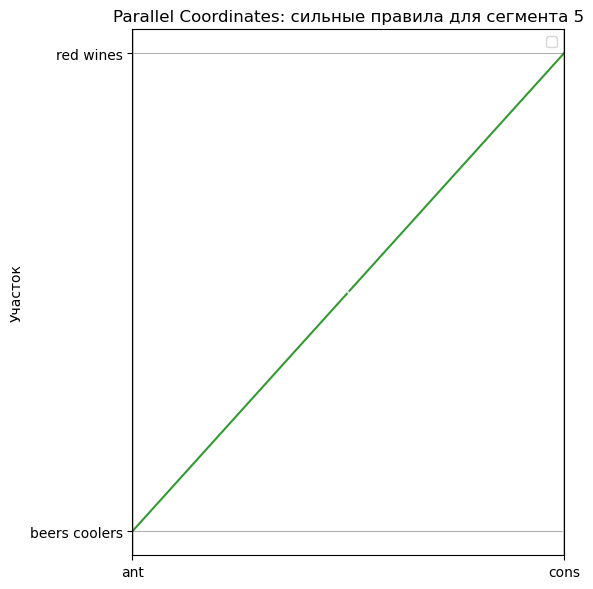

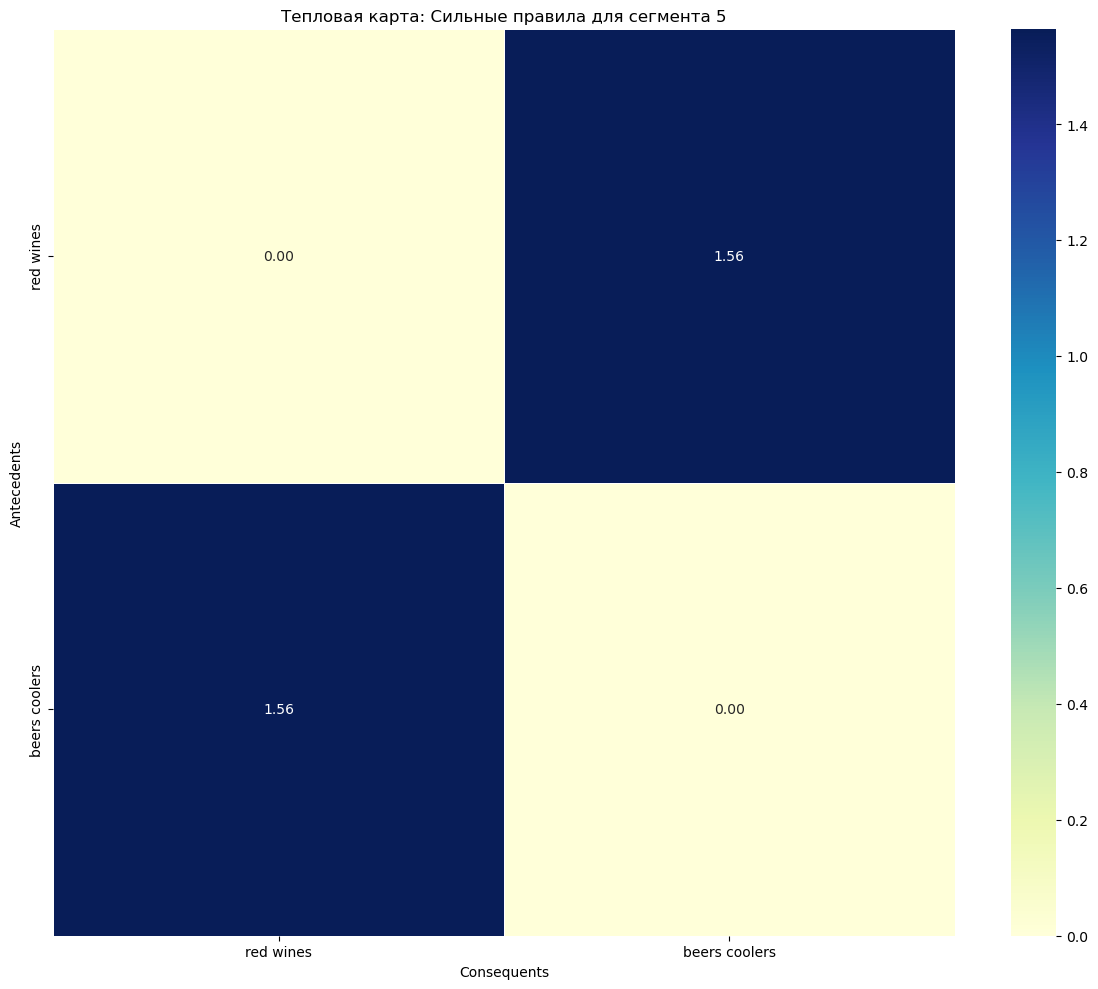

Сегмент заказов 6
Частых aisle (≥1 % и прошли фильтрацию): 71
basket: (125022, 71)
  → сильных правил: 5



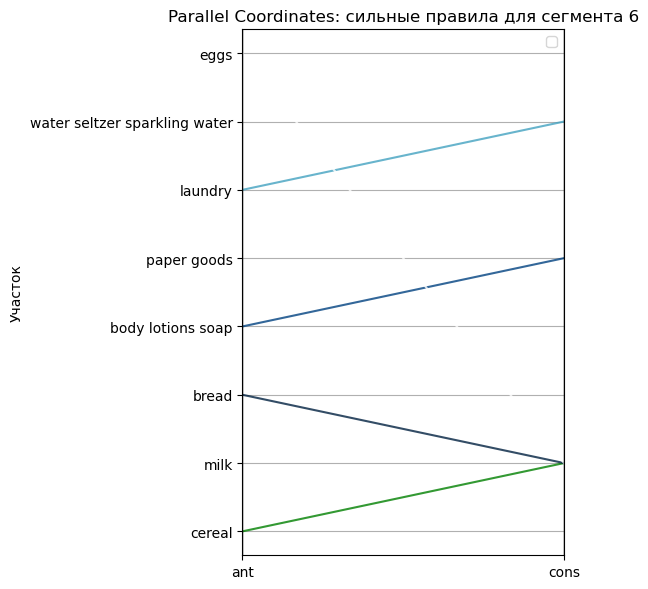

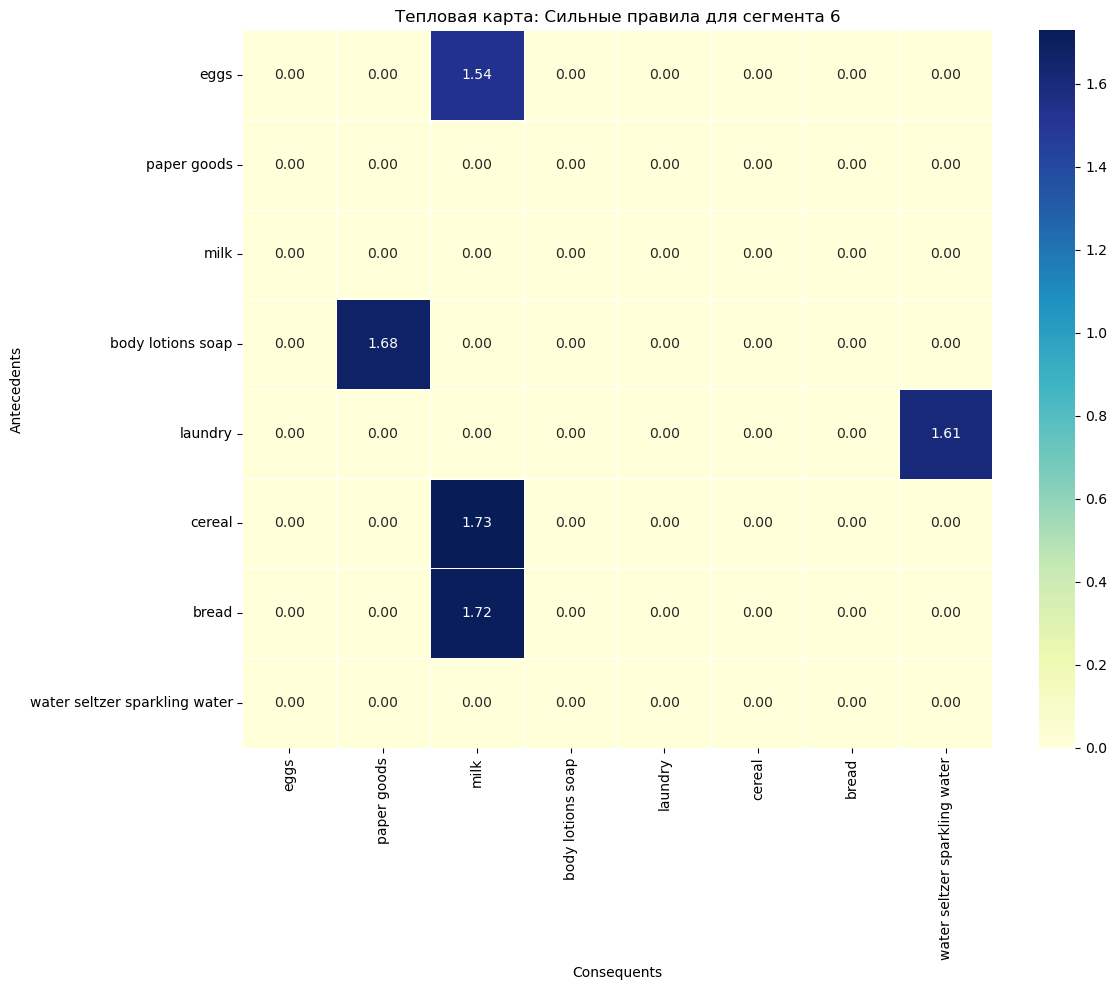

In [8]:
# %% -------------------- 3. Майним правила ПО СЕГМЕНТАМ ЗАКАЗОВ --------------------
seg_rule_lists = {}            # <-- теперь ключи = order‑segment
all_frequent_aisles = set()    # соберём объединённый список частых 'aisle'

for seg, df_seglist in order_cluster.groupby('order_segment'):
    print(f"Сегмент заказов {seg}")

    # фильтруем заказы ТЕКУЩЕГО сегмента
    df_seg = df[df['order'].isin(df_seglist['order'])]

    # --- 1. support по отдельным aisle --------------------------
    n_orders = df_seg["order"].nunique()
    min_cnt  = int(0.01 * n_orders)           # 1 %

    order_cnts = df_seg.groupby("aisle")["order"].nunique()
    frequent_aisles = order_cnts[order_cnts >= min_cnt].index

    # 🔥 Исключаем слишком популярные и редкие категории, как в сегментации!
    frequent_aisles = [a for a in frequent_aisles if a not in exclude_aisles]

    all_frequent_aisles.update(frequent_aisles)   # для test‑корзины
    print(f"Частых aisle (≥1 % и прошли фильтрацию): {len(frequent_aisles)}")

    # --- 2. basket‑матрица --------------------------------------
    df_unique = df_seg[df_seg["aisle"].isin(frequent_aisles)].drop_duplicates(["order", "aisle"])
    basket = pd.crosstab(df_unique["order"], df_unique["aisle"]).astype("uint8")
    print(f"basket: {basket.shape}")

    # --- 3. Apriori + правила -----------------------------------
    freq_itemsets = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)
    rules = (
        association_rules(freq_itemsets, metric="support", min_threshold=0.01)
          .sort_values(["support", "lift"], ascending=False)
          .reset_index(drop=True)
    )

    # --- 4. фильтр «сильных» правил (порог как у вас) -----------
    filtered = (
        rules[
            (rules["antecedent support"] >= 0.01) & #0.02
            (rules["consequent support"] >= 0.01) & #0.02
            (rules["confidence"]         >= 0.20) &
            (rules["lift"]               >= 1.50)
        ]
        .sort_values("lift", ascending=False)
        .reset_index(drop=True)
    )
    seg_rule_lists[seg] = filtered
    print(f"  → сильных правил: {len(filtered)}\n")
    
    # Преобразуем правила в удобный формат для визуализации
    def to_coords(df_rules):
        df = df_rules.copy()
        df["ant"]  = df["antecedents"].apply(lambda s: list(s)[0])
        df["cons"] = df["consequents"].apply(lambda s: list(s)[0])
        df["rule"] = df.index.astype(str)
        return df[["ant", "cons", "rule"]]
    
    coords = to_coords(filtered)
    
    # Параллельные координаты для визуализации
    plt.figure(figsize=(6, 6))
    parallel_coordinates(coords, "rule", colormap="ocean", alpha=0.8)
    plt.title(f"Parallel Coordinates: сильные правила для сегмента {seg}")
    plt.ylabel("Участок")
    plt.legend([], [])  # убираем легенду
    plt.tight_layout()
    plt.show()
    
    # Преобразуем правила в удобный формат для визуализации
    def to_coords2(df_rules):
        df = df_rules.copy()
        df["ant"]  = df["antecedents"].apply(lambda s: list(s)[0])
        df["cons"] = df["consequents"].apply(lambda s: list(s)[0])
        df["rule"] = df.index.astype(str)
        return df[["ant", "cons", "rule", "lift"]]
    
    coords2 = to_coords2(filtered)
    
    # Визуализируем тепловую карту
    # Создадим таблицу для heatmap: строки — antecedents, столбцы — consequents
    aisles = list(set(coords2['ant'].unique()) | set(coords2['cons'].unique()))  # Уникальные участки
    heatmap_data = pd.DataFrame(0, index=aisles, columns=aisles, dtype=float)
    
    # Заполняем таблицу значениями lift для каждой пары antecedent → consequent
    for _, r in filtered.iterrows():
        a = list(r["antecedents"])[0]
        b = list(r["consequents"])[0]
        heatmap_data.loc[a, b] = r["lift"]
    
    # Настроим размер и отобразим тепловую карту
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
    plt.title(f"Тепловая карта: Сильные правила для сегмента {seg}")
    plt.xlabel("Consequents")
    plt.ylabel("Antecedents")
    plt.tight_layout()
    plt.show()

In [9]:
# %% -------------------- 4. TEST‑корзина (order_products__train) --------------------
df_pr   = pd.read_csv(os.path.join(DATA_DIR, "products.csv"))

df_test = (
    pd.read_csv(os.path.join(DATA_DIR, "order_products__train.csv"))
      .merge(df_pr[["product_id", "aisle_id"]], on="product_id", how="left")
      .merge(df_aisl, on="aisle_id", how="left")
      .rename(columns={"order_id": "order"})
      .loc[:, ["order", "aisle"]]
      .drop_duplicates(["order", "aisle"])
)
df_test = df_test[df_test["aisle"].isin(all_frequent_aisles)]
basket_test = pd.crosstab(df_test["order"], df_test["aisle"]).astype("uint8")

# присоединяем колонку order_segment
basket_test = basket_test.merge(order_cluster, on="order", how="left")
print("test‑basket:", basket_test.shape)
basket_test.head()

test‑basket: (127488, 100)


,order,air fresheners candles,asian foods,baby food formula,baking ingredients,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,...,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trash bags liners,water seltzer sparkling water,white wines,order_segment
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,98,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [10]:
# %% -------------------- 5. Проверка train_vs_test CONF (order‑seg ↔ order‑seg)
#     + фильтр правил по минимальной уверенности на тесте
# ------------------------------------------------------------------------------
min_conf_test = 0.05 #0.05                      # Порог test‑confidence
good_rules = {seg: [] for seg in seg_rule_lists}   # «прошедшие» правила

for test_seg, b_test_seg in basket_test.groupby('order_segment'):
    print(f"\n→ Тестовый order‑сегмент {test_seg}  (заказов: {len(b_test_seg)})")
    base = b_test_seg.drop(columns=['order_segment'])       # bool‑матрица

    for train_seg, rules in seg_rule_lists.items():
        for _, r in rules.iterrows():
            a = list(r["antecedents"])[0]
            b = list(r["consequents"])[0]

            if a not in base.columns or b not in base.columns:
                continue
            orders_with_a = base[base[a] == 1]
            if orders_with_a.empty:
                continue

            conf_test = (orders_with_a[b] == 1).mean()

            # ---- фильтр по test‑confidence ----
            if conf_test >= min_conf_test:
                good_rules[train_seg].append(r)
            # -----------------------------------

            #print(f"[train‑seg {train_seg}] {a} → {b}: "
                  #f"train_conf={r['confidence']:.2f}, test_conf={conf_test:.2f}")

# Превращаем списки в DataFrame‑ы
good_rules = {seg: pd.DataFrame(lst) if lst else pd.DataFrame()
              for seg, lst in good_rules.items()}



→ Тестовый order‑сегмент 0  (заказов: 103372)

→ Тестовый order‑сегмент 1  (заказов: 2215)

→ Тестовый order‑сегмент 2  (заказов: 589)

→ Тестовый order‑сегмент 3  (заказов: 527)

→ Тестовый order‑сегмент 4  (заказов: 12081)

→ Тестовый order‑сегмент 5  (заказов: 540)

→ Тестовый order‑сегмент 6  (заказов: 8164)


In [15]:
# %% -------------------- 6. Допфильтр по Precision / Recall каждого правила (OPT) ----------
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from joblib import Parallel, delayed          # pip install joblib (если ещё нет)

# ──────────────────────────── ПАРАМЕТРЫ ──────────────────────────────
k_top         = 5       # @k  в precision / recall
min_prec_rule = 0.10 #0.10    # пороги
min_rec_rule  = 0.05 #0.05
n_jobs        = -1      # =‑1 → все ядра; =1 → без параллели

# ─────────────────── ФУНКЦИИ ВЕКТОРНОГО РАСЧЁТА ──────────────────────
def pr_for_rules_vec(base_mat: np.ndarray,
                     true_len: np.ndarray,
                     idx_a: np.ndarray,
                     idx_b: np.ndarray,
                     k: int = 5):
    """
    Precision / Recall для правил «a ⇒ b».
    В Precision учитываем ТОЛЬКО consequent b.
    """
    rec_size = 1                              # рекомендуем 1 товар – b

    # --- попали ли мы consequent‑ом b (без antecedent‑а!) ---
    hits_mat = base_mat[:, idx_b]             # (M, R) bool

    prec = hits_mat.mean(axis=0) / min(k, rec_size)   # Precision@k (k ≥ 1 → делим на 1)

    mask = true_len > 0
    if mask.any():
        recall = (hits_mat[mask] / true_len[mask, None]).mean(axis=0)
    else:
        recall = np.zeros_like(prec)

    return prec, recall


def filter_rules_for_pair(basket_seg: pd.DataFrame,
                          rules_df: pd.DataFrame,
                          k: int = 5,
                          p_thr: float = 0.10,
                          r_thr: float = 0.05):
    """
    Фильтрует rules_df (train‑segment) для одного basket_seg (test‑segment).
    Возвращает список выбранных правил (itertuples).
    """
    if basket_seg.empty or rules_df.empty:
        return []

    # ----- матрица заказов -----
    base_mat = basket_seg.to_numpy(dtype=bool)
    true_len = base_mat.sum(axis=1)

    item2col = {it: i for i, it in enumerate(basket_seg.columns)}

    # ----- оставляем правила, у которых Оба товара есть в колонках -----
    mask_valid = (
        rules_df["antecedents"].map(lambda s: next(iter(s)) in item2col) &
        rules_df["consequents"].map(lambda s: next(iter(s)) in item2col)
    )
    rules_valid = rules_df[mask_valid]
    if rules_valid.empty:
        return []

    idx_a = rules_valid["antecedents"].map(lambda s: item2col[next(iter(s))]).to_numpy()
    idx_b = rules_valid["consequents"].map(lambda s: item2col[next(iter(s))]).to_numpy()

    # ----- векторные precision / recall для всех правил -----
    prec, rec = pr_for_rules_vec(base_mat, true_len, idx_a, idx_b, k)

    keep = (prec >= p_thr) & (rec >= r_thr)
    return list(rules_valid[keep].itertuples(index=False))

# ───────────────────── ОСНОВНОЙ ПРОХОД ПО СЕГМЕНТАМ ──────────────────
final_rules = {seg: [] for seg in good_rules}    # good_rules из предыдущих шагов

for test_seg, basket_seg in tqdm(basket_test.groupby('order_segment'),
                                 desc="Test‑segments", ncols=100):          # basket_test как раньше
    base = basket_seg.drop(columns=['order_segment'])

    # ——— параллель по train‑сегментам (при желании) ———
    def _proc(tr):
        train_seg, rules = tr
        kept = filter_rules_for_pair(base, rules,
                                     k=k_top, p_thr=min_prec_rule, r_thr=min_rec_rule)
        return train_seg, kept

    results = Parallel(n_jobs=n_jobs)(
        delayed(_proc)(tr) for tr in good_rules.items()
    )

    for train_seg, kept in results:
        final_rules[train_seg].extend(kept)

# ───────────────────── ФОРМИРУЕМ seg_rule_lists БЕЗ ДУБЛИКАТОВ ─────────────────────
seg_rule_lists = {}
for seg, lst in final_rules.items():
    if not lst:                       # пусто?
        seg_rule_lists[seg] = pd.DataFrame()
        continue

    df = pd.DataFrame(lst)
    df = df.drop_duplicates(subset=["antecedents", "consequents"])  # <-- ключ!
    seg_rule_lists[seg] = df

    print(f"Сегмент {seg}: уникальных правил после фильтра — {len(df)}")


Test‑segments:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Сегмент 1: уникальных правил после фильтра — 3
Сегмент 3: уникальных правил после фильтра — 13
Сегмент 4: уникальных правил после фильтра — 24
Сегмент 5: уникальных правил после фильтра — 1
Сегмент 6: уникальных правил после фильтра — 1


In [17]:
def get_actual_dict(basket):
    """order ➜ set(aisles)"""
    return {oid: set(row.index[row == 1]) for oid, row in basket.iterrows()}

def precision_recall_matrix_orders(basket_test, k=5):
    actual = get_actual_dict(basket_test.drop(columns=['order_segment']))

    order_segs = list(seg_rule_lists.keys())
    prec = pd.DataFrame(index=order_segs, columns=order_segs, dtype=float)
    rec  = prec.copy()

    basket_by_seg = {
        seg: basket_test[basket_test['order_segment'] == seg]
              .drop(columns=['order_segment'])
        for seg in order_segs
    }

    # внешний прогресс: тестовые сегменты
    for test_seg, basket_seg in tqdm(basket_by_seg.items(),
                                     desc="PR-метрики: тестовые сегменты",
                                     ncols=100):
        if basket_seg.empty:
            continue
        for train_seg, rules in seg_rule_lists.items():
            if basket_seg.empty or rules.empty:
                continue

            p_list, r_list = [], []
            for _, rule in rules.iterrows():
                a = list(rule["antecedents"])[0]
                b = list(rule["consequents"])[0]
                if a not in basket_seg.columns or b not in basket_seg.columns:
                    continue
                rec_items = {b}
                for oid in basket_seg.index:
                    true_items = actual[oid]
                    hit = int(b in true_items)
                    if true_items:
                        p_list.append(hit / min(k, len(rec_items)))
                        r_list.append(hit / len(true_items))
            if p_list:                               # если остались валидные правила
                prec.loc[train_seg, test_seg] = np.mean(p_list)
                rec.loc[train_seg,  test_seg] = np.mean(r_list)
    return prec, rec

precision_df, recall_df = precision_recall_matrix_orders(basket_test, k=5)

print("\nPrecision@5  (строки = train‑segment, столбцы = test‑segment):")
display(precision_df.fillna(0).style.format("{:.3f}").background_gradient("Blues"))

print("\nRecall@5:")
display(recall_df.fillna(0).style.format("{:.3f}").background_gradient("Greens"))

PR-метрики: тестовые сегменты:   0%|                                          | 0/7 [00:00<?, ?it/s]


Precision@5  (строки = train‑segment, столбцы = test‑segment):


,0,1,2,3,4,5,6
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.012,0.605,0.008,0.005,0.015,0.003,0.024
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.002,0.000,0.000,0.757,0.002,0.000,0.000
4,0.030,0.053,0.013,0.061,0.488,0.015,0.022
5,0.004,0.003,0.012,0.002,0.004,0.713,0.004
6,0.054,0.106,0.061,0.030,0.058,0.050,0.438



Recall@5:


,0,1,2,3,4,5,6
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.001,0.129,0.002,0.001,0.001,0.001,0.003
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.172,0.000,0.000,0.000
4,0.003,0.007,0.003,0.011,0.086,0.004,0.003
5,0.001,0.001,0.003,0.001,0.001,0.279,0.001
6,0.007,0.020,0.015,0.005,0.007,0.012,0.127


In [18]:
# после того как seg_rule_lists сформирован в пайплайне майнинга
import joblib, json
from pathlib import Path

ART_DIR = Path('model_artifacts'); ART_DIR.mkdir(exist_ok=True)

joblib.dump(seg_rule_lists, ART_DIR/'seg_rule_lists.pkl')
print('✅  seg_rule_lists.pkl сохранён')


✅  seg_rule_lists.pkl сохранён
